# 🛡️ Malicious Domain Detection via DNS Data Analysis and Transformer Modeling

## Brief Description

This notebook focuses on selecting the proper features for the detection of **malicious domains** (phishing, malware, etc.) using metadata from DNS records. The workflow is organized into two main phases:

- Phase 1: DNS JSON Preprocessing and Flattening

- Phase 2: Textual Feature Analysis for Model Input

---

## ✅ Outcome

By the end of this notebook:
- You will have a clean, analysis-ready DNS dataset.
- You will understand which DNS fields are most discriminative.
- You’ll be ready to feed selected fields into a transformer model to classify domains as **malicious** or **benign** with improved efficiency.

---


# Phase 1: RDAP JSON Preprocessing and Flattening

**Goal:**  
Prepare DNS data for analysis by transforming MongoDB-exported JSON files into a structured tabular format.

**Input Format:**
- A JSON file where each line represents a document containing:
  - `"domain_name"`: the domain string.
  - `"dns"`: a nested object with DNS data.

**Processing Steps:**
1. Load each line from the JSON file into memory.
2. Flatten the nested `"dns"` object using `pandas.json_normalize`.
3. Drop the MongoDB-generated `"_id"` field.
4. Optionally, clean up column names by removing the `rdap.` prefix.

**Output:**
A `pandas.DataFrame` where each row represents a domain, and columns include all flattened DNS metadata fields — ready for further analysis.


In [1]:
import json
import random 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import HTML
from typing import Optional, List, Dict

In [2]:


def render_dataframe(df, max_rows=100, max_cols=50):
    styles = [
        dict(selector="th", props=[("max-width", "200px")]),
        dict(selector="td", props=[("max-width", "200px"), ("overflow", "auto"), ("text-overflow", "ellipsis")]),
    ]
    return HTML(df.head(max_rows).style.set_table_styles(styles).set_table_attributes('style="display:inline-block;overflow:auto;max-height:500px;"').to_html())

def read_json_file(file_path: str) -> pd.DataFrame:
    # Read the JSON file line by line
    with open(file_path, 'r') as f:
        data = [json.loads(line) for line in f]

    # Flatten the JSON structure; each nested key from 'rdap' becomes a column like 'rdap.handle', etc.
    df = pd.json_normalize(data, sep='.')

    # Drop _id columns 
    df = df.drop(columns=[col for col in df.columns if col.startswith('_id')])

    # Remove the "rdap." prefix from column names for clarity
    df.columns = [col.replace('dns.', '') for col in df.columns]
    return df 

# Construct the path to the JSON file relative to this script's location.
script_path = Path.cwd()
# Go up 3 levels to the project root (from transformers/data -> transformers -> project_root)
project_root = script_path.parent.parent

In [3]:
def _sample_jsonl_lines(file_path: str, sample_size: int, total_lines: int, seed: int) -> List[Dict]:
    """
    Randomly samples lines from a JSONL file using a 2-pass strategy.

    Args:
        file_path (str): Path to the JSONL file.
        sample_size (int): Number of lines to sample.
        total_lines (int): Total number of lines in the file.
        seed (int): Random seed for reproducibility.

    Returns:
        List[Dict]: List of sampled JSON objects.
    """
    random.seed(seed)
    selected_indices = set(random.sample(range(total_lines), sample_size))
    data = []

    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if i in selected_indices:
                data.append(json.loads(line))
            if len(data) >= sample_size:
                break  # Optional: early exit

    return data

def read_json_file_to_df(file_path: str, sample_size: Optional[int] = None,
                         seed: int = 42, flatten_depth: Optional[int] = None) -> pd.DataFrame:
    """
    Reads a JSONL RDAP file and returns a pandas DataFrame with controlled flattening of nested keys.
    If sample_size is provided and smaller than total lines, randomly samples those lines.

    Args:
        file_path (str): Path to the JSONL file.
        sample_size (int, optional): Number of records to sample. If None or exceeds file size, loads full file.
        seed (int): Random seed for reproducibility.
        flatten_depth (int, optional): Maximum depth to flatten nested JSON keys. If None, flattens fully.

    Returns:
        pd.DataFrame: DataFrame with 'domain_name' and RDAP fields.
    """
    # Count total lines in the JSONL file
    with open(file_path, 'r') as f:
        total_lines = sum(1 for _ in f)

    # Load either the full file or a sampled subset
    if sample_size is None or sample_size >= total_lines:
        with open(file_path, 'r') as f:
            data = [json.loads(line) for line in f]
    else:
        data = _sample_jsonl_lines(file_path, sample_size, total_lines, seed)

    # Flatten the JSON objects with a controlled depth if flatten_depth is provided.
    # Note: max_level is passed only when flatten_depth is not None.
    if flatten_depth is not None:
        df = pd.json_normalize(data, sep='.', max_level=flatten_depth)
    else:
        df = pd.json_normalize(data, sep='.')

    # Optionally drop columns that start with '_id'
    df = df.drop(columns=[col for col in df.columns if col.startswith('_id')], errors='ignore')

    # Optionally remove the 'dns.' prefix from column names
    df.columns = [col.replace('dns.', '') for col in df.columns]

    return df

### Benign

In [4]:
benign_file_path = project_root / "datasets" / "benign" / "benign_2312_anonymized_dns_2024.json"
benign_df = read_json_file_to_df(benign_file_path, sample_size=160_000, flatten_depth=1)
render_dataframe(benign_df)

,domain_name,A,AAAA,CNAME,MX,NS,TXT,SOA,zone_SOA,dnssec,remarks,sources,ttls,NAPTR
0,00000fs3085d.han2.savba.sk,['147.213.4.22'],None,None,None,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 0, 'AAAA': 2, 'SOA': 2, 'CNAME': 2, 'MX': 2, 'NS': 2, 'TXT': 2, 'NAPTR': 2}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",nan
1,0000100b00e9.han2.savba.sk,['147.213.4.22'],None,None,None,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 0, 'AAAA': 2, 'SOA': 2, 'CNAME': 2, 'MX': 2, 'NS': 2, 'TXT': 2, 'NAPTR': 2}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",nan
2,0000100q012c.han2.savba.sk,['147.213.4.22'],None,None,None,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 0, 'AAAA': 2, 'SOA': 2, 'CNAME': 2, 'MX': 2, 'NS': 2, 'TXT': 2, 'NAPTR': 2}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",nan
3,0000102n02c4.han2.savba.sk,['147.213.4.22'],None,None,None,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 0, 'AAAA': 2, 'SOA': 2, 'CNAME': 2, 'MX': 2, 'NS': 2, 'TXT': 2, 'NAPTR': 2}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",nan
4,0000102n02d5.han2.savba.sk,['147.213.4.22'],None,None,None,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 0, 'AAAA': 2, 'SOA': 2, 'CNAME': 2, 'MX': 2, 'NS': 2, 'TXT': 2, 'NAPTR': 2}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",nan
5,0000102n03d3.han2.savba.sk,['147.213.4.22'],None,None,None,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 0, 'AAAA': 2, 'SOA': 2, 'CNAME': 2, 'MX': 2, 'NS': 2, 'TXT': 2, 'NAPTR': 2}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",nan
6,0000102n0434.han2.savba.sk,['147.213.4.22'],None,None,None,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}

In [5]:
benign_df.info()
benign_df.columns.to_list()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   domain_name  160000 non-null  object
 1   A            131619 non-null  object
 2   AAAA         34528 non-null   object
 3   CNAME        16210 non-null   object
 4   MX           83075 non-null   object
 5   NS           98681 non-null   object
 6   TXT          81208 non-null   object
 7   SOA          99055 non-null   object
 8   zone_SOA     60536 non-null   object
 9   dnssec       158027 non-null  object
 10  remarks      158027 non-null  object
 11  sources      158027 non-null  object
 12  ttls         158027 non-null  object
 13  NAPTR        46 non-null      object
dtypes: object(14)
memory usage: 17.1+ MB


['domain_name',
 'A',
 'AAAA',
 'CNAME',
 'MX',
 'NS',
 'TXT',
 'SOA',
 'zone_SOA',
 'dnssec',
 'remarks',
 'sources',
 'ttls',
 'NAPTR']

### Phishing

In [6]:
# Now build the path to the JSON file in datasets/malware/
json_file_path = project_root / "datasets" / "phishing" / "phishing_strict_dns_2024.json"
# json_file_path = project_root / "datasets" / "malware" / "malware_strict_dns_2024.json"
phish_df = read_json_file_to_df(json_file_path, flatten_depth=1)
render_dataframe(phish_df)

,domain_name,A,AAAA,CNAME,MX,NS,TXT,SOA,zone_SOA,dnssec,remarks,sources,ttls
0,conflrma57843.com,"['188.114.97.9', '188.114.96.9']","['2a06:98c1:3121::9', '2a06:98c1:3120::9']",None,None,"{'aisha.ns.cloudflare.com': {'related_ips': [{'ttl': 82617, 'value': '108.162.194.186'}, {'ttl': 82617, 'value': '162.159.38.186'}, {'ttl': 82617, 'value': '172.64.34.186'}, {'ttl': 81928, 'value': '2803:f800:50::6ca2:c2ba'}, {'ttl': 81928, 'value': '2a06:98c1:50::ac40:22ba'}, {'ttl': 81928, 'value': '2606:4700:50::a29f:26ba'}]}, 'rommy.ns.cloudflare.com': {'related_ips': [{'ttl': 54785, 'value': '108.162.195.20'}, {'ttl': 54785, 'value': '162.159.44.20'}, {'ttl': 54785, 'value': '172.64.35.20'}, {'ttl': 60359, 'value': '2803:f800:50::6ca2:c314'}, {'ttl': 60359, 'value': '2a06:98c1:50::ac40:2314'}, {'ttl': 60359, 'value': '2606:4700:58::a29f:2c14'}]}}",None,"{'primary_ns': 'aisha.ns.cloudflare.com', 'resp_mailbox_dname': 'dns.cloudflare.com', 'serial': 2339702964, 'refresh': 10000, 'retry': 2400, 'expire': 604800, 'min_ttl': 1800}",None,"{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'conflrma57843.com'}","{'A': 0, 'AAAA': 0, 'SOA': 0, 'CNAME': 2, 'MX': 2, 'NS': 0, 'TXT': 2, 'NAPTR': 2}","{'A': 300, 'AAAA': 300, 'SOA': 1800, 'CNAME': 0, 'MX': 0, 'NS': 86400, 'TXT': 0, 'NAPTR': 0}"
1,www.zgahdjm.com,None,None,None,None,None,None,None,None,nan,nan,nan,nan
2,attt.pages.dev,"['172.66.44.147', '172.66.47.109']","['2606:4700:310c::ac42:2c93', '2606:4700:310c::ac42:2f6d']",None,None,"{'lily.ns.cloudflare.com': {'related_ips': [{'ttl': 85625, 'value': '173.245.58.130'}, {'ttl': 85625, 'value': '108.162.192.130'}, {'ttl': 85625, 'value': '172.64.32.130'}, {'ttl': 83677, 'value': '2606:4700:50::adf5:3a82'}, {'ttl': 83677, 'value': '2803:f800:50::6ca2:c082'}, {'ttl': 83677, 'value': '2a06:98c1:50::ac40:2082'}]}, 'watson.ns.cloudflare.com': {'related_ips': [{'ttl': 83409, 'value': '172.64.35.23'}, {'ttl': 83409, 'value': '108.162.195.23'}, {'ttl': 83409, 'value': '162.159.44.23'}, {'ttl': 84450, 'value': '2606:4700:58::a29f:2c17'}, {'ttl': 84450, 'value': '2803:f800:50::6ca2:c317'}, {'ttl': 84450, 'value': '2a06:98c1:50::ac40:2317'}]}}",None,"{'primary_ns': 'lily.ns.cloudflare.com', 'resp_mailbox_dname': 'dns.cloudflare.com', 'serial': 2327161952, 'refresh': 10000, 'retry': 2400, 'expire': 604800, 'min_ttl': 1800}",None,"{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'attt.pages.dev'}","{'A': 0, 'AAAA': 0, 'SOA': 0, 'CNAME': 2, 'MX': 2, 'NS': 0, 'TXT': 2, 'NAPTR': 2}","{'A': 300, 'AAAA': 300, 'SOA': 1800, 'CNAME': 0, 'MX': 0, 'NS': 86400, 'TXT': 0, 'NAPTR': 0}"
3,chermate.weeblysite.com,"['162.159.140.60', '172.66.0.60']",None,None,None,None,None,None,"{'primary_ns': 'dns1.p08.nsone.net', 'resp_mailbox_dname': 'hostmaster.nsone.net', 'serial': 1647889018, 'refresh': 43200, 'retry': 7200, 'expire': 1209600, 'min_ttl': 3600}","{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'weeblysite.com'}","{'A': 0, 'AAAA': 2, 'SOA': 2, 'CNAME': 2, 'MX': 2, 'NS': 2, 'TXT': 2, 'NAPTR': 2}","{'A': 900, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}"
4,allegrolokalnie.oferta73.pl,['84.32.84.33'],None,None,None,"{'ns1.dns-expired.com': {'related_ips': [{'ttl': 14147, 'value': '89.116.146.145'}]}, 'ns2.dns-expired.com': {'related_ips': [{'ttl': 14730, 'value': '89.116.146.146'}]}}",['this domain is expired at hostinger!'],"{'primary_ns': 'ns1.dns-expired.com', 'resp_mailbox_dname': 'hostmaster.hostinger.com', 'serial': 2023081800, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 3600}",None,"{'A': 3, 'AAAA': 3, 'SOA': 3, 'CNAME': 3, 'MX': 3, 'NS': 3, 'TXT': 3, 'NAPTR': 3}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'al

In [7]:
phish_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164425 entries, 0 to 164424
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   domain_name  164425 non-null  object
 1   A            113923 non-null  object
 2   AAAA         49022 non-null   object
 3   CNAME        25848 non-null   object
 4   MX           15052 non-null   object
 5   NS           32543 non-null   object
 6   TXT          24783 non-null   object
 7   SOA          33121 non-null   object
 8   zone_SOA     127602 non-null  object
 9   dnssec       160052 non-null  object
 10  remarks      160052 non-null  object
 11  sources      160052 non-null  object
 12  ttls         160052 non-null  object
dtypes: object(13)
memory usage: 16.3+ MB


# Phase 2: Textual Feature Analysis for Model Input

**Goal:**  
Identify the most informative **textual DNS fields** for input into a transformer-based model for malicious domain classification.

**Steps:**
1. **Handle missing values**
2. **Text Field Extraction:**  
   Collect all string-based fields from the flattened DataFrame.
3. **Feature Engineering:**  
   For each field, compute numerical representations such as:
   - String length
   - Character entropy
   - Alphanumeric ratios
   - Word count, etc.
4. **Statistical Evaluation:**  
   - Visualize distributions (histograms, KDEs).
   - Perform hypothesis testing (e.g., t-test, Mann-Whitney U) to assess significance between malicious and benign domains.
5. **Feature Selection:**  
   Rank and select fields that show strong statistical signals or unique distribution patterns across classes.


## Handling of missing values

### Columns with any NaN (missing values)
Before hadnling the Nan values, it is clear that some columns appear that they are not empty, because they do not contain NaN values. But this is false, because by analyzing the columns, it is clear that some of them contain empty strings '' or empty lists '[]'. Therefore, for better analysis will be these values replaced by NaN.

In [8]:
# Benign
nan_columns = benign_df.columns[benign_df.isna().any()].tolist()
print("Benign:")
print(f"Number of columns containing any NaN value: {len(nan_columns)}")
print(f"Total number of columns: {len(benign_df.columns.to_list())}")
print("---------------------------------------------------------------")
# Malware
nan_columns = phish_df.columns[phish_df.isna().any()].tolist()
print("Malware:")
print(f"Number of columns containing any NaN value: {len(nan_columns)}")
print(f"Total number of columns: {len(phish_df.columns.to_list())}")

Benign:
Number of columns containing any NaN value: 13
Total number of columns: 14
---------------------------------------------------------------
Malware:
Number of columns containing any NaN value: 12
Total number of columns: 13


### Columns That Are Fully Empty (All Values Are NaN)
These columns can be fully dropped

In [9]:
# Benign
fully_nan_benign = benign_df.columns[benign_df.isna().all()].tolist()
print("Benign:")
print("Columns with only NaN values:", fully_nan_benign)
print("---------------------------------------------------------------")

# Phishing
fully_nan_phishing = phish_df.columns[phish_df.isna().all()].tolist()
print("Phishing:")
print("Columns with only NaN values:", fully_nan_phishing)

Benign:
Columns with only NaN values: []
---------------------------------------------------------------
Phishing:
Columns with only NaN values: []


In [10]:
# Benign
print("Benign:") 
print("Before:", benign_df.shape)
benign_df.drop(columns=fully_nan_benign, inplace=True, errors="ignore")
print("After:", benign_df.shape)
print("---------------------------------------------------------------")
# Phishing
print("Phishing:") 
print("Before:", phish_df.shape)
phish_df.drop(columns=fully_nan_phishing, inplace=True, errors="ignore")
print("After:", phish_df.shape)

Benign:
Before: (160000, 14)
After: (160000, 14)
---------------------------------------------------------------
Phishing:
Before: (164425, 13)
After: (164425, 13)


In [11]:
missing_counts = phish_df.isna().sum()
print(missing_counts[missing_counts > 0])

A            50502
AAAA        115403
CNAME       138577
MX          149373
NS          131882
TXT         139642
SOA         131304
zone_SOA     36823
dnssec        4373
remarks       4373
sources       4373
ttls          4373
dtype: int64


In [12]:
common_columns = set(phish_df.columns) & set(benign_df.columns)
print("Number of common columns:", len(common_columns))
print("Common columns:")
print(common_columns)

different_columns = set(benign_df.columns) - set(phish_df.columns)
print("Number of different columns:", len(different_columns))
print("Different columns:")
print(different_columns)

Number of common columns: 13
Common columns:
{'TXT', 'CNAME', 'sources', 'zone_SOA', 'ttls', 'SOA', 'A', 'NS', 'MX', 'AAAA', 'remarks', 'domain_name', 'dnssec'}
Number of different columns: 1
Different columns:
{'NAPTR'}


In [13]:
# Assuming common_columns is your set of column names
benign_df.drop(columns=different_columns, inplace=True, errors="ignore")

In [14]:
# Benign
print(benign_df.info())
# Malware
print(phish_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   domain_name  160000 non-null  object
 1   A            131619 non-null  object
 2   AAAA         34528 non-null   object
 3   CNAME        16210 non-null   object
 4   MX           83075 non-null   object
 5   NS           98681 non-null   object
 6   TXT          81208 non-null   object
 7   SOA          99055 non-null   object
 8   zone_SOA     60536 non-null   object
 9   dnssec       158027 non-null  object
 10  remarks      158027 non-null  object
 11  sources      158027 non-null  object
 12  ttls         158027 non-null  object
dtypes: object(13)
memory usage: 15.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164425 entries, 0 to 164424
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   domain_name 

<Figure size 1200x600 with 0 Axes>

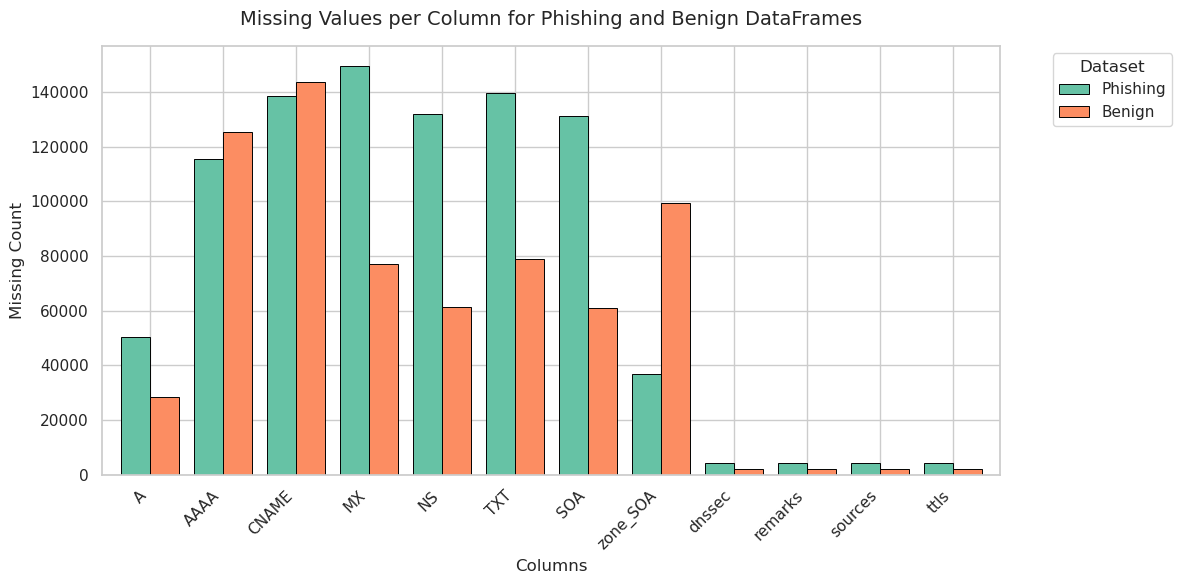

In [15]:
# 1. Calculate missing counts
missing_phish = phish_df.isna().sum()
missing_benign = benign_df.isna().sum()

# 2. Combine the counts into one DataFrame
missing_counts = pd.DataFrame({
    'Phishing': missing_phish,
    'Benign': missing_benign
})

# 3. (Optional) Filter to only columns with missing values
missing_counts = missing_counts[(missing_counts['Phishing'] > 0) | (missing_counts['Benign'] > 0)]

# 4. Use Seaborn to set a modern style/theme
sns.set_theme(style="whitegrid")

# 5. Create a grouped bar chart
plt.figure(figsize=(12, 6))

# Here, we specify a palette from Seaborn (e.g., "Set2", "husl", "deep", etc.)
# We'll pick two colors from a palette for 'Phish' and 'Benign'.
colors = sns.color_palette("Set2", n_colors=2)

# missing_counts.plot.bar returns an Axes object, so we capture it
ax = missing_counts.plot(
    kind='bar',
    color=colors,
    width=0.8,
    edgecolor='black',
    linewidth=0.7,
    figsize=(12, 6)
)

# 6. Customize labels and title
ax.set_title("Missing Values per Column for Phishing and Benign DataFrames", fontsize=14, pad=15)
ax.set_xlabel("Columns", fontsize=12)
ax.set_ylabel("Missing Count", fontsize=12)

# 7. Improve x-axis label rotation and spacing
plt.xticks(rotation=45, ha='right')

# 8. Move the legend outside the plot (optional)
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')

# 9. Adjust layout so everything fits
plt.tight_layout()

# 10. Show the plot
plt.show()


<Figure size 1200x600 with 0 Axes>

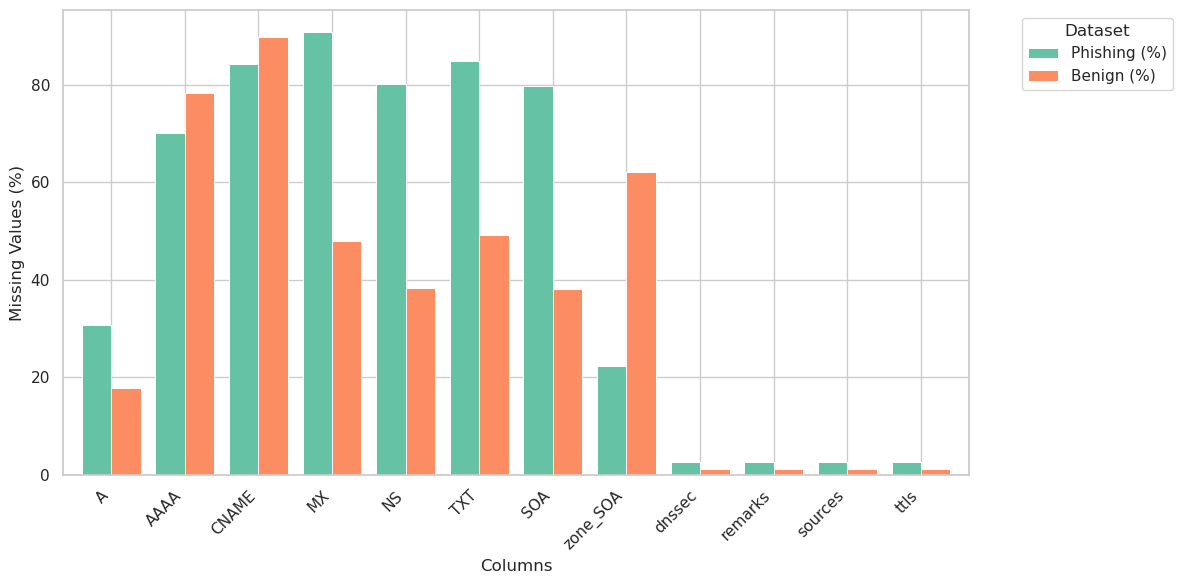

In [16]:
# 1. Calculate the proportion (percentage) of missing values per column
phish_missing_pct = phish_df.isna().sum() / len(phish_df) * 100
benign_missing_pct = benign_df.isna().sum() / len(benign_df) * 100

# 2. Combine into one DataFrame
missing_pct = pd.DataFrame({
    'Phishing (%)': phish_missing_pct,
    'Benign (%)': benign_missing_pct
})

# 3. (Optional) Filter to only columns that have missing values in at least one DataFrame
missing_pct = missing_pct[(missing_pct['Phishing (%)'] > 0) | (missing_pct['Benign (%)'] > 0)]

# 4. Set a modern Seaborn theme
sns.set_theme(style="whitegrid")

# 5. Plot a grouped bar chart
plt.figure(figsize=(12, 6))
colors = sns.color_palette("Set2", n_colors=2)
ax = missing_pct.plot(
    kind='bar',
    color=colors,
    width=0.8,
    # edgecolor='black',
    linewidth=0.7,
    figsize=(12, 6)
)

# 6. Customize the title and labels
# ax.set_title("Percentage of Missing Values per Column\nMalware vs. Benign DataFrames", fontsize=14, pad=15)
ax.set_xlabel("Columns", fontsize=12)
ax.set_ylabel("Missing Values (%)", fontsize=12)

# 7. Improve x-axis label rotation
plt.xticks(rotation=45, ha='right')

# 8. Move the legend (optional)
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')

# 9. Tight layout for readability
plt.tight_layout()

# 10. Display the plot
plt.show()


In [17]:
# Function to compute Cohen's h between two proportions
def cohens_h(p1, p2):
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

results = {}

# Iterate over all columns (assuming both dataframes have the same columns)
for col in benign_df.columns.to_list():
    # Calculate the proportion of missing values for each group
    malware_missing_pct = phish_df[col].isna().sum() / len(phish_df)
    benign_missing_pct = benign_df[col].isna().sum() / len(benign_df)
    
    # Calculate Cohen's h (absolute value to focus on the magnitude of the difference)
    h_value = abs(cohens_h(malware_missing_pct, benign_missing_pct))
    
    results[col] = {
        'malware_missing_pct': malware_missing_pct,
        'benign_missing_pct': benign_missing_pct,
        "Cohen's h": h_value
    }

# Create a DataFrame for easier visualization and sort by effect size (largest differences first)
results_df = pd.DataFrame(results).T.sort_values("Cohen's h", ascending=False)
print("Cohen's h and missing percentages for each column:")
print(results_df)

# Set a threshold for a minimal effect size. Here, features with Cohen's h below this value are considered not informative.
threshold = 0.2

# Identify columns that have an effect size smaller than the threshold
features_to_drop = results_df[results_df["Cohen's h"] < threshold].index.tolist()

print("\nFeatures recommended to drop (Cohen's h < {}):".format(threshold))
print(features_to_drop)

Cohen's h and missing percentages for each column:
             malware_missing_pct  benign_missing_pct  Cohen's h
MX                      0.908457            0.480781   0.994486
NS                      0.802080            0.383244   0.884400
SOA                     0.798565            0.380906   0.880417
zone_SOA                0.223950            0.621650   0.830647
TXT                     0.849275            0.492450   0.788469
A                       0.307143            0.177381   0.305353
AAAA                    0.701858            0.784200   0.188985
CNAME                   0.842798            0.898687   0.167512
dnssec                  0.026596            0.012331   0.105076
sources                 0.026596            0.012331   0.105076
remarks                 0.026596            0.012331   0.105076
ttls                    0.026596            0.012331   0.105076
domain_name             0.000000            0.000000   0.000000

Features recommended to drop (Cohen's h < 0.2):
['AA

In [18]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Helper function to handle arrays
def is_missing(x):
    """
    Return 1 if the value is considered missing, otherwise 0.
    Considers NaN, empty strings (after stripping), empty lists, and empty numpy arrays as missing.
    """
    # Check if x is an array or list and if it's empty
    if isinstance(x, (list, np.ndarray)):
        if len(x) == 0:
            return 1
        else:
            return 0
    # For scalar values, use pd.isna
    if pd.isna(x):
        return 1
    if isinstance(x, str) and x.strip() == "":
        return 1
    return 0

# -------------------------------
# Step 1: Combine the DataFrames
# -------------------------------
# Assume benign_df and malicious_df are your two dataframes.
benign_df['label'] = 0  # 0 for benign
phish_df['label'] = 1  # 1 for malicious

# Combine the two dataframes into one.
df = pd.concat([benign_df, phish_df], ignore_index=True)
print("Combined dataframe shape:", df.shape)

# -----------------------------------------------
# Step 2: Compute Missingness Indicator & Build Contingency Tables
# -----------------------------------------------
# List of columns to analyze (adjust as needed)
cols_to_check = benign_df.columns.tolist() + phish_df.columns.tolist()

# Dictionary to store results
missing_stats = {}

for col in cols_to_check:
    if col in df.columns:
        # Create a temporary missingness indicator series for the column.
        missing_indicator = df[col].apply(is_missing)
        overall_missing_rate = missing_indicator.mean()
        
        # Build a contingency table: rows = missing indicator, columns = label
        contingency = pd.crosstab(missing_indicator, df['label'])
        
        # Run chi-square test if both classes are present in the contingency table.
        if contingency.shape[1] == 2:
            chi2, p, dof, expected = chi2_contingency(contingency)
        else:
            p = 1.0  # Set non-significant if one of the classes is missing.
        
        missing_stats[col] = {
            'overall_missing_rate': overall_missing_rate,
            'chi2_p_value': p,
            'contingency_table': contingency
        }
        
        print(f"Column: {col}")
        print(f"  Overall Missing Rate: {overall_missing_rate:.2f}")
        print(f"  Chi-Square p-value: {p:.4f}")
        print(f"  Contingency Table:\n{contingency}\n")

# ------------------------------------------------------
# Step 3: Decide on Columns to Drop or Retain
# ------------------------------------------------------
# For example, drop columns if overall missing rate is above 70% and p-value > 0.05
columns_to_drop = []

for col, stats in missing_stats.items():
    if stats['overall_missing_rate'] > 0.7 and stats['chi2_p_value'] > 0.05:
        columns_to_drop.append(col)
        print(f"Candidate to drop: {col} (Missing rate: {stats['overall_missing_rate']:.2f}, p-value: {stats['chi2_p_value']:.4f})")

print("\nFinal list of columns to drop based on missingness and statistical test:")
print(columns_to_drop)


Combined dataframe shape: (324425, 14)
Column: domain_name
  Overall Missing Rate: 0.00
  Chi-Square p-value: 1.0000
  Contingency Table:
label             0       1
domain_name                
0            160000  164425

Column: A
  Overall Missing Rate: 0.24
  Chi-Square p-value: 0.0000
  Contingency Table:
label       0       1
A                    
0      131619  113923
1       28381   50502

Column: AAAA
  Overall Missing Rate: 0.74
  Chi-Square p-value: 0.0000
  Contingency Table:
label       0       1
AAAA                 
0       34528   49022
1      125472  115403

Column: CNAME
  Overall Missing Rate: 0.87
  Chi-Square p-value: 0.0000
  Contingency Table:
label       0       1
CNAME                
0       16210   25848
1      143790  138577

Column: MX
  Overall Missing Rate: 0.70
  Chi-Square p-value: 0.0000
  Contingency Table:
label      0       1
MX                  
0      83075   15052
1      76925  149373

Column: NS
  Overall Missing Rate: 0.60
  Chi-Square p-value:

In [19]:
# Set your missingness threshold (70% in this case)
missing_threshold = 0.70

# Calculate the fraction of missing values for each column in both DataFrames
phish_missing_pct = phish_df.isna().mean()
benign_missing_pct = benign_df.isna().mean()

# Identify columns exceeding the threshold in either dataset
phish_high_missing = phish_missing_pct[phish_missing_pct > missing_threshold].index
benign_high_missing = benign_missing_pct[benign_missing_pct > missing_threshold].index

# Combine into a single set (or list) of columns to drop
features_high_missing = set(phish_high_missing).union(set(benign_high_missing))

print("Features with missingness > 70% in at least one DataFrame:")
print(features_high_missing)


Features with missingness > 70% in at least one DataFrame:
{'TXT', 'SOA', 'CNAME', 'NS', 'AAAA', 'MX'}


### Inspection of columns which should be dropped according to statistical analysis

#### TXT

In [20]:
# benign_df["TXT"].value_counts()

#### MX

In [21]:
# print(benign_df["MX"].value_counts())
# print("---------------------")
# print(phish_df["MX"].value_counts())

### Dropping the columns

In [22]:

numerical_columns = ["A", "dnssec","sources"]
columns_to_drop = list(features_high_missing - {"MX", "NS", "SOA"}) + numerical_columns
print("Columns to drop:")
print(columns_to_drop)

# Drop the identified columns from the DataFrame
benign_df.drop(columns=columns_to_drop, inplace=True, errors="ignore")
phish_df.drop(columns=columns_to_drop, inplace=True, errors="ignore")

Columns to drop:
['AAAA', 'CNAME', 'TXT', 'A', 'dnssec', 'sources']


In [23]:
render_dataframe(benign_df, max_rows=100, max_cols=50)

,domain_name,MX,NS,SOA,zone_SOA,remarks,ttls,label
0,00000fs3085d.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
1,0000100b00e9.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
2,0000100q012c.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
3,0000102n02c4.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
4,0000102n02d5.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
5,0000102n03d3.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
6,0000102n0434.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
7,000010560066.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
8,0000105600be.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0
9,000010640021.han2.savba.sk,None,None,None,"{'primary_ns': 'savba.savba.sk', 'resp_mailbox_dname': 'postmaster.savba.sk', 'serial': 2022332560, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'savba.sk'}","{'A': 86400, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",0


In [24]:
render_dataframe(phish_df, max_rows=100, max_cols=50)

,domain_name,MX,NS,SOA,zone_SOA,remarks,ttls,label
0,conflrma57843.com,None,"{'aisha.ns.cloudflare.com': {'related_ips': [{'ttl': 82617, 'value': '108.162.194.186'}, {'ttl': 82617, 'value': '162.159.38.186'}, {'ttl': 82617, 'value': '172.64.34.186'}, {'ttl': 81928, 'value': '2803:f800:50::6ca2:c2ba'}, {'ttl': 81928, 'value': '2a06:98c1:50::ac40:22ba'}, {'ttl': 81928, 'value': '2606:4700:50::a29f:26ba'}]}, 'rommy.ns.cloudflare.com': {'related_ips': [{'ttl': 54785, 'value': '108.162.195.20'}, {'ttl': 54785, 'value': '162.159.44.20'}, {'ttl': 54785, 'value': '172.64.35.20'}, {'ttl': 60359, 'value': '2803:f800:50::6ca2:c314'}, {'ttl': 60359, 'value': '2a06:98c1:50::ac40:2314'}, {'ttl': 60359, 'value': '2606:4700:58::a29f:2c14'}]}}","{'primary_ns': 'aisha.ns.cloudflare.com', 'resp_mailbox_dname': 'dns.cloudflare.com', 'serial': 2339702964, 'refresh': 10000, 'retry': 2400, 'expire': 604800, 'min_ttl': 1800}",None,"{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'conflrma57843.com'}","{'A': 300, 'AAAA': 300, 'SOA': 1800, 'CNAME': 0, 'MX': 0, 'NS': 86400, 'TXT': 0, 'NAPTR': 0}",1
1,www.zgahdjm.com,None,None,None,None,nan,nan,1
2,attt.pages.dev,None,"{'lily.ns.cloudflare.com': {'related_ips': [{'ttl': 85625, 'value': '173.245.58.130'}, {'ttl': 85625, 'value': '108.162.192.130'}, {'ttl': 85625, 'value': '172.64.32.130'}, {'ttl': 83677, 'value': '2606:4700:50::adf5:3a82'}, {'ttl': 83677, 'value': '2803:f800:50::6ca2:c082'}, {'ttl': 83677, 'value': '2a06:98c1:50::ac40:2082'}]}, 'watson.ns.cloudflare.com': {'related_ips': [{'ttl': 83409, 'value': '172.64.35.23'}, {'ttl': 83409, 'value': '108.162.195.23'}, {'ttl': 83409, 'value': '162.159.44.23'}, {'ttl': 84450, 'value': '2606:4700:58::a29f:2c17'}, {'ttl': 84450, 'value': '2803:f800:50::6ca2:c317'}, {'ttl': 84450, 'value': '2a06:98c1:50::ac40:2317'}]}}","{'primary_ns': 'lily.ns.cloudflare.com', 'resp_mailbox_dname': 'dns.cloudflare.com', 'serial': 2327161952, 'refresh': 10000, 'retry': 2400, 'expire': 604800, 'min_ttl': 1800}",None,"{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'attt.pages.dev'}","{'A': 300, 'AAAA': 300, 'SOA': 1800, 'CNAME': 0, 'MX': 0, 'NS': 86400, 'TXT': 0, 'NAPTR': 0}",1
3,chermate.weeblysite.com,None,None,None,"{'primary_ns': 'dns1.p08.nsone.net', 'resp_mailbox_dname': 'hostmaster.nsone.net', 'serial': 1647889018, 'refresh': 43200, 'retry': 7200, 'expire': 1209600, 'min_ttl': 3600}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'weeblysite.com'}","{'A': 900, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",1
4,allegrolokalnie.oferta73.pl,None,"{'ns1.dns-expired.com': {'related_ips': [{'ttl': 14147, 'value': '89.116.146.145'}]}, 'ns2.dns-expired.com': {'related_ips': [{'ttl': 14730, 'value': '89.116.146.146'}]}}","{'primary_ns': 'ns1.dns-expired.com', 'resp_mailbox_dname': 'hostmaster.hostinger.com', 'serial': 2023081800, 'refresh': 10800, 'retry': 3600, 'expire': 604800, 'min_ttl': 3600}",None,"{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'allegrolokalnie.oferta73.pl'}","{'A': 3600, 'AAAA': 0, 'SOA': 3600, 'CNAME': 0, 'MX': 0, 'NS': 3600, 'TXT': 3600, 'NAPTR': 0}",1
5,validarnavegador.com,None,None,None,"{'primary_ns': 'a.gtld-servers.net', 'resp_mailbox_dname': 'nstld.verisign-grs.com', 'serial': 1698658384, 'refresh': 1800, 'retry': 900, 'expire': 604800, 'min_ttl': 86400}","{'has_dnskey': True, 'zone_dnskey_selfsign_ok': True, 'zone': 'com'}","{'A': 0, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",1
6,contraato.salonqs.cl,None,None,None,"{'primary_ns': 'ns1.sitiodns.net', 'resp_mailbox_dname': 'jsotom.gmail.com', 'serial': 2024041200, 'refresh': 3600, 'retry': 7200, 'expire': 1209600, 'min_ttl': 86400}","{'has_dnskey': False, 'zone_dnskey_selfsign_ok': False, 'zone': 'salonqs.cl'}","{'A': 0, 'AAAA': 0, 'SOA': 0, 'CNAME': 0, 'MX': 0, 'NS': 0, 'TXT': 0, 'NAPTR': 0}",1
7,assets-project-cloud.reconfirmation-zip.workers.dev,None,None,None,"{'primar

In [25]:
# Define the columns to check (all except domain_name, label, and dnssec) if they are all NaN
cols_to_check = [col for col in benign_df.columns if col not in ['domain_name', 'label']]
print(cols_to_check)

# Create a boolean mask that is True when all of the selected columns are NaN for a given row
mask_all_nan_benign = benign_df[cols_to_check].isna().all(axis=1)
mask_all_nan_malware = phish_df[cols_to_check].isna().all(axis=1)

# Count the rows where all these columns are NaN
num_rows_all_nan_benign = mask_all_nan_benign.sum()
num_rows_all_nan_phish = mask_all_nan_malware.sum()

# Print the counts
print("Number of NaN rows in Benign dataframe:", num_rows_all_nan_benign)
print("Number of NaN rows in Malware dataframe:", num_rows_all_nan_phish)
benign_df.drop(index=benign_df[mask_all_nan_benign].index, inplace=True, errors="ignore")
phish_df.drop(index=phish_df[mask_all_nan_malware].index, inplace=True, errors="ignore")
print(benign_df.shape, phish_df.shape)

['MX', 'NS', 'SOA', 'zone_SOA', 'remarks', 'ttls']
Number of NaN rows in Benign dataframe: 1973
Number of NaN rows in Malware dataframe: 4373
(158027, 8) (160052, 8)


In [26]:
columns_to_check = ["remarks", "SOA"]

for col in columns_to_check:
    unique_keys = set()
    for cell in df[col]:
        if isinstance(cell, dict):
            unique_keys.update(cell.keys())
    print(f"Unique keys in '{col}':", unique_keys)


Unique keys in 'remarks': {'zone', 'has_dmarc', 'has_dnskey', 'has_spf', 'has_dkim', 'zone_dnskey_selfsign_ok'}
Unique keys in 'SOA': {'min_ttl', 'expire', 'refresh', 'primary_ns', 'resp_mailbox_dname', 'serial', 'retry'}


<Figure size 1200x600 with 0 Axes>

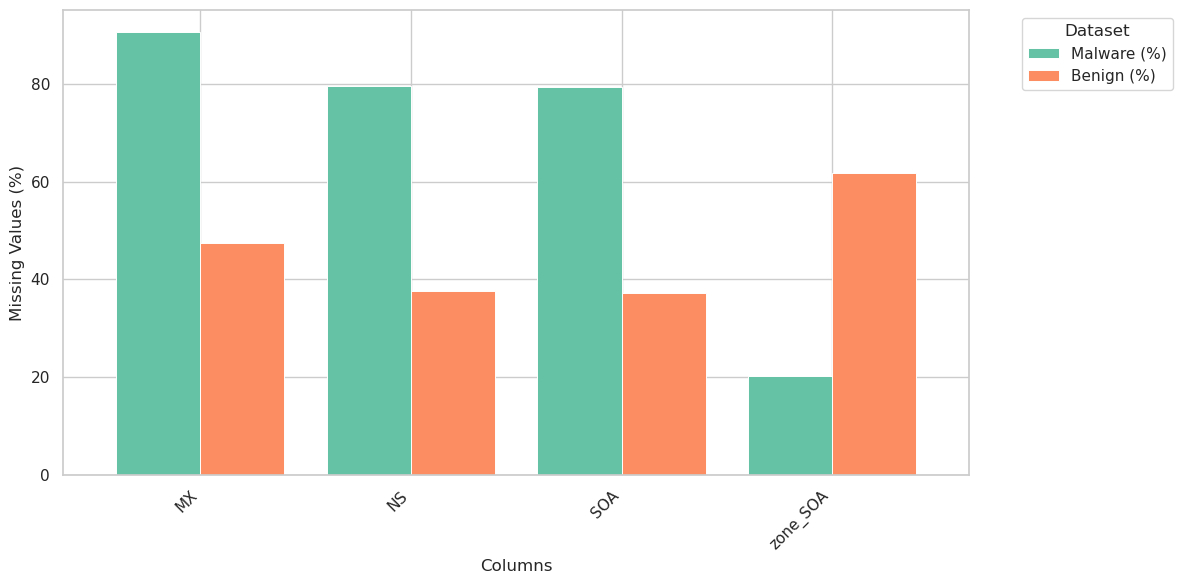

In [27]:
# 1. Calculate the proportion (percentage) of missing values per column
malware_missing_pct = phish_df.isna().sum() / len(phish_df) * 100
benign_missing_pct = benign_df.isna().sum() / len(benign_df) * 100

# 2. Combine into one DataFrame
missing_pct = pd.DataFrame({
    'Malware (%)': malware_missing_pct,
    'Benign (%)': benign_missing_pct
})

# 3. (Optional) Filter to only columns that have missing values in at least one DataFrame
missing_pct = missing_pct[(missing_pct['Malware (%)'] > 0) | (missing_pct['Benign (%)'] > 0)]

# 4. Set a modern Seaborn theme
sns.set_theme(style="whitegrid")

# 5. Plot a grouped bar chart
plt.figure(figsize=(12, 6))
colors = sns.color_palette("Set2", n_colors=2)
ax = missing_pct.plot(
    kind='bar',
    color=colors,
    width=0.8,
    # edgecolor='black',
    linewidth=0.7,
    figsize=(12, 6)
)

# 6. Customize the title and labels
# ax.set_title("Percentage of Missing Values per Column\nMalware vs. Benign DataFrames", fontsize=14, pad=15)
ax.set_xlabel("Columns", fontsize=12)
ax.set_ylabel("Missing Values (%)", fontsize=12)

# 7. Improve x-axis label rotation
plt.xticks(rotation=45, ha='right')

# 8. Move the legend (optional)
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')

# 9. Tight layout for readability
plt.tight_layout()

# 10. Display the plot
plt.show()


## Prepare the dataframe for trasnformer training


In [28]:
benign_df['NS'] = benign_df['NS'].apply(lambda x: list(x.keys()) if isinstance(x, dict) else x)
phish_df['NS'] = phish_df['NS'].apply(lambda x: list(x.keys()) if isinstance(x, dict) else x)

For training the transformer, it is neccessary to create a one concatenated string with fields from analyzed dataframe

In [29]:
# Example helper function to format the input string.
def prepare_input_string(row):
    CLS_TOKEN = "[CLS]"
    SEP_TOKEN = "[SEP]"
    tokens = []
    
    # Process domain_name: simply lowercase and remove leading "www."
    domain = row.get("domain_name", "NA")
    if isinstance(domain, str):
        domain = domain.lower().lstrip("www.")
    else:
        domain = "NA"
    tokens.append(f"domain: {domain}")
    
    # Process MX: if present and is a dict, extract keys only
    mx = row.get("MX")
    if mx and isinstance(mx, dict):
        mx_keys = list(mx.keys())
        mx_joined = ", ".join(mx_keys) if mx_keys else "NA"
        tokens.append(f"MX: {mx_joined}")
    else:
        tokens.append("MX: NA")
    
    # Process NS: if present and is a list
    ns = row.get("NS")
    if ns and isinstance(ns, list) and len(ns) > 0:
        ns_joined = ", ".join(ns)
        tokens.append(f"NS: {ns_joined}")
    else:
        tokens.append("NS: NA")
    
    # Process SOA: extract textual items (primary_ns and resp_mailbox_dname)
    soa = row.get("SOA")
    if soa and isinstance(soa, dict):
        primary_ns = soa.get("primary_ns", "NA")
        resp_mailbox_dname = soa.get("resp_mailbox_dname", "NA")
        tokens.append(f"SOA: primary_ns: {primary_ns} | resp_mailbox_dname: {resp_mailbox_dname}")
    else:
        tokens.append("SOA: NA")
    
    # Process zone_SOA similarly to SOA
    zone_soa = row.get("zone_SOA")
    if zone_soa and isinstance(zone_soa, dict):
        primary_ns_z = zone_soa.get("primary_ns", "NA")
        resp_mailbox_dname_z = zone_soa.get("resp_mailbox_dname", "NA")
        tokens.append(f"zone_SOA: primary_ns: {primary_ns_z} | resp_mailbox_dname: {resp_mailbox_dname_z}")
    else:
        tokens.append("zone_SOA: NA")
    
    # Process remarks: for this example, we extract only keys whose values are strings
    remarks = row.get("remarks")
    if remarks and isinstance(remarks, dict):
        # Filter out non-string values (e.g., booleans)
        filtered_pairs = [f"{k}: {v}" for k, v in remarks.items() if isinstance(v, str) and v.strip() != ""]
        token_r = "remarks: " + " | ".join(filtered_pairs) if filtered_pairs else "remarks: NA"
        tokens.append(token_r)
    else:
        tokens.append("remarks: NA")
        
    # Concatenate all tokens with the [SEP] token in between, starting with [CLS] and ending with [SEP]
    input_str = f"{CLS_TOKEN} " + f" {SEP_TOKEN} ".join(tokens) + f" {SEP_TOKEN}"
    return input_str

# For demonstration, suppose you have two DataFrames:
# benign_df with columns: domain_name, MX, NS, SOA, zone_SOA, remarks, label
# phish_df with the same structure.

# Here we create a small dummy example (in real usage you'll be reading your actual data)


# Create the input string for each DataFrame row
benign_df['input_string'] = benign_df.apply(prepare_input_string, axis=1)
phish_df['input_string'] = phish_df.apply(prepare_input_string, axis=1)

# Combine into a single DataFrame for training (exclude the label from tokenization)
combined_df = pd.concat(
    [benign_df[['input_string', 'label']], phish_df[['input_string', 'label']]],
    ignore_index=True
)

# Optionally shuffle the rows
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the result
print(combined_df.head())


                                        input_string  label
0  [CLS] domain: tvetreform.org.pk [SEP] MX: mx2....      0
1  [CLS] domain: bonjour.alsace [SEP] MX: alt1.as...      0
2  [CLS] domain: lowcarb.institute [SEP] MX: smtp...      0
3  [CLS] domain: tend.kiev.ua [SEP] MX: mx15.ukra...      0
4  [CLS] domain: jamricgayojs04.pages.dev [SEP] M...      1


In [30]:
# combined_df.info()
# save_path = project_root / "datasets" / "phishing" / "dns_phishing_preprocessed.csv"
# combined_df.to_csv(save_path, index=False)


In [31]:
# save_path = project_root / "datasets" / "malware" / "dns_malware_preprocessed.csv"
# combined_df.to_csv(save_path, index=False)

In [32]:
max_length = combined_df['input_string'].str.len().max()
print(max_length)

645


## Determine the max length of tokens for tokenizer

In [33]:
from transformers import AutoTokenizer

/home/fetagpu/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


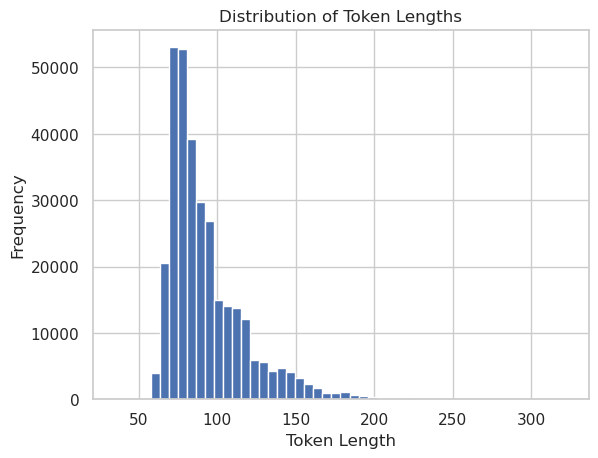

95th percentile: 145.0
99th percentile: 180.0


In [34]:
# Load your tokenizer and a sample of your dataset
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Assume text is in 'input_string' column
token_lengths = combined_df['input_string'].apply(lambda x: len(tokenizer.tokenize(str(x))))

# Plot histogram
plt.hist(token_lengths, bins=50)
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.title("Distribution of Token Lengths")
plt.show()

# Get percentiles
percentile_95 = np.percentile(token_lengths, 95)
percentile_99 = np.percentile(token_lengths, 99)
print("95th percentile:", percentile_95)
print("99th percentile:", percentile_99)